In [1]:
import numpy as np
import cvxpy as cp
import random
import math
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy import ndimage
import pandas as pd
import pyvoro as voro

User defined PSD

       diam       vol       rad      freq       cfd
0   0.25200  6.082205  0.126000  0.319165  0.000000
1   0.28650  6.200998  0.143250  0.217191  0.319165
2   0.32550  6.272274  0.162750  0.148103  0.536356
3   0.36975  6.319791  0.184875  0.101040  0.684459
4   0.42000  6.319791  0.210000  0.068940  0.785499
5   0.47625  6.319791  0.238125  0.047284  0.854438
6   0.54375  6.319791  0.271875  0.031770  0.901722
7   0.61500  6.319791  0.307500  0.021958  0.933492
8   0.70125  6.319791  0.350625  0.014811  0.955450
9   0.79500  6.343550  0.397500  0.010165  0.970262
10  0.90375  6.343550  0.451875  0.006919  0.980427
11  1.02750  6.343550  0.513750  0.004708  0.987346
12  1.16625  6.296032  0.583125  0.003220  0.992055
13  1.32375  6.200998  0.661875  0.002202  0.995275
14  1.50375  6.082205  0.751875  0.001502  0.997476
15  1.71000  5.915895  0.855000  0.001021  0.998979
16  1.94250  0.000000  0.971250  0.000000  1.000000


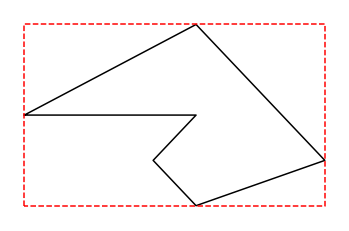

In [2]:
polygon = np.array([[1, 3],
       [5, 5],
       [8, 2],
       [5, 1],
       [4, 2],
       [5, 3],
       [1, 3]])

xmin,ymin = min(polygon[:,0]),min(polygon[:,1])
xmax,ymax = max(polygon[:,0]),max(polygon[:,1])
width,height = xmax-xmin,ymax-ymin
# xmin -= width*0.1
# xmax += width*0.1
# ymin -= height*0.1
# ymax += height*0.1
# width,height = xmax-xmin,ymax-ymin

plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
plt.xlim([xmin-0.4,xmax+0.4])
plt.ylim([ymin-0.4,ymax+0.4])
plt.axis('off')
# plt.title('bounded polygon')
# plt.savefig('./figs/1', dpi=300)
# plt.show()


size_dist = pd.read_csv('./PSD/PSD30-70.csv',delimiter='\t',names=['diam','vol'])
size_dist['diam'] = size_dist['diam']/200 #convert from m to μm
size_dist['rad'] = size_dist['diam']/2
size_dist['freq'] = size_dist['vol']/(size_dist['vol'] * (size_dist['rad'])**3)
size_dist['freq'] = size_dist['freq']/(size_dist['freq'].sum())
size_dist['freq'] = size_dist['freq'].fillna(0.)
cfd = [0]
for i,v in enumerate(size_dist['freq'][:-1]):
    cfd.append(v+cfd[i])
size_dist['cfd'] = cfd
print('User defined PSD\n')
print(size_dist)
dmin = size_dist['diam'].min()
dmax = size_dist['diam'].max()

In [3]:
def generate_radius():
    #This function generates a new particle radius sampled from the user defined PSD
    rnd =  np.random.random()
    i = 0
    while rnd > size_dist['cfd'][i+1] and i<len(size_dist['cfd']): i+=1
    return (size_dist['rad'][i] + ((rnd - size_dist['cfd'][i])*(size_dist['rad'][i+1]-size_dist['rad'][i]))/(size_dist['cfd'][i+1]-size_dist['cfd'][i]))

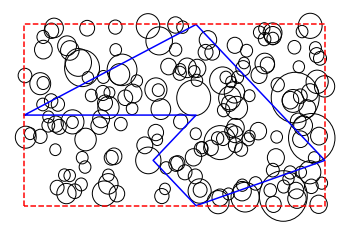

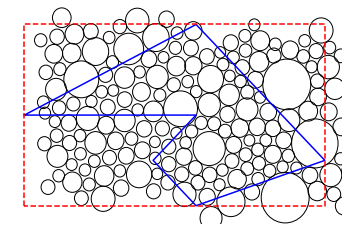

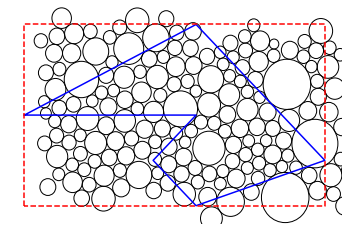

Packing density of clump = 0.8335984697417865


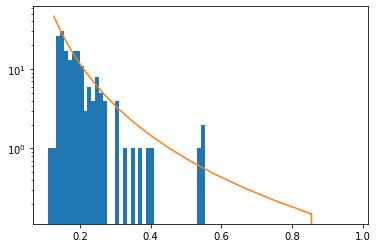

In [97]:
volume  = width*height
target_den = 0.8
den = 0
radii = []
while(den < target_den):
    radius = generate_radius()
    den += (np.pi * radius**2)/volume
    radii.append(radius)

pos = []
for i in range(len(radii)):
    pos.append(np.random.random(2)*[width,height]+[xmin,ymin])
pos = np.array(pos)

particles = np.array((pos[:,0],pos[:,1],radii)).T
show_particles(particles)
vor,particles = lloyds(particles,10)
show_particles(particles)

particles_dense = []

for i in vor:
    verts = i['vertices']
    verts = [j.tolist() for j in verts]
    verts = np.array(verts+[verts[0]])
    
    inscribed_circle = circ_inscribe(verts)
    particles_dense.append(inscribed_circle)

show_particles(particles_dense)

plt.hist(np.array(particles_dense)[:,2],bins=40)
plt.plot(size_dist['rad'],size_dist['freq']*len(radii)*pack_den(particles_dense))
plt.yscale('log')

In [89]:
## Conventional Lloyds algorythm
def lloyds(particles,steps):
    scale = 0
    for i in range(100):

        vor = voro.compute_2d_voronoi(
        particles[:,:2],
        [[xmin,xmax], [ymin,ymax]], # limits
        2.0, # block size
        radii=particles[:,2]*scale, # particle radii -- optional, and keyword-compatible arg.
        periodic = [True]*2
        )
        for j,cell in enumerate(vor):
            particles[j][0] = Polygon(cell['vertices']).centroid.x
            particles[j][1] = Polygon(cell['vertices']).centroid.y
        if(i<10):
            scale += 0.1

        # if(i%2 == 0):
        #     fig, ax = plt.subplots()
        #     plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
        #     plt.xlim([xmin-0.4,xmax+0.4])
        #     plt.ylim([ymin-0.4,ymax+0.4])
        #     plt.axis('off')

        #     for j in particles:
        #         plt.plot(j[0],j[1],'b.')
        #         # particle = plt.Circle((i[0],i[1]), i[2], fill=False)
        #         # particle = plt.Circle((i[0],i[1]), i[2], fill=True)#, color='lightsteelblue')
        #         # ax.add_patch(particle)

        #     for j in vor:
        #         poly = Polygon(j['vertices'])
        #         x,y = poly.exterior.xy
        #         plt.plot(x,y,'black')
        #     plt.savefig(f'./gif/lloyds/{i}',dpi=300)


    return(vor,particles)

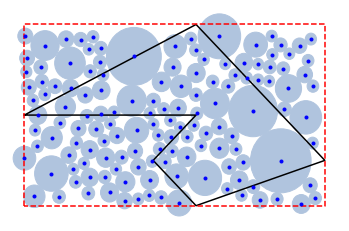

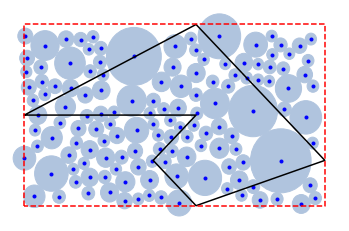

In [31]:
#(Bridson,2007) Fast Poisson Disk Sampling in Arbitrary Dimensions
#constants

fig, ax = plt.subplots()
plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
plt.xlim([xmin-0.4,xmax+0.4])
plt.ylim([ymin-0.4,ymax+0.4])
# plt.title('point sampling')
plt.axis('off')
n = 2 #Dimensions
attempts = 30
#initialise grid
w = dmin
search_range = math.ceil(dmax/dmin)
cols = int(width/w)
rows = int(height/w)
grid = np.array([[None,None,None]]*cols*rows) #empty grid to store points and radii
active = []
n_part = 1

#step 1: pick a random starting point
pos = np.concatenate((np.random.rand(n)*[width,height], [generate_radius()]), axis=0)
col = int(pos[0]/w)
row = int(pos[1]/w)
grid[col+row*cols] = pos
active.append(pos)
plt.plot(pos[0]+xmin,pos[1]+ymin,'b.')
particle = plt.Circle((pos[0]+xmin,pos[1]+ymin), pos[2], fill=True, color='lightsteelblue')
ax.add_patch(particle)
# plt.savefig(f'./gif/disk_sampling/{n_part}',dpi = 300)

#step 2: Poission disc sampling algorythm
r_new = generate_radius()
while len(active) > 0:
    randID = random.randint(0,len(active)-1)
    pos = active[randID]
    found = False
    for i in range(attempts):
        valid_sample = True
        a1 = random.random()*2*np.pi
        r = pos[2]+r_new
        sample = [pos[0]+np.sin(a1)*r, pos[1]+np.cos(a1)*r, r_new]
        if(sample[0]<0 or sample[1]<0):
            valid_sample = False
        col =int(sample[0]/w)
        row = int(sample[1]/w)
        #check sample validity
        if(col>-1 and row>-1 and col<cols and row<rows and not grid[col+row*cols][0]):
            for i in range(-search_range,search_range+1):
                for j in range(-search_range,search_range+1):                    
                    neighbour = grid[((col+i+cols)%cols)+((row+j+rows)%rows)*cols].tolist()
                    if(neighbour[0]):
                        #periodic neighbour check
                        if(col+i>cols-1): neighbour[0]+= width
                        if(row+j>rows-1): neighbour[1] += height
                        if(col+i<0): neighbour[0] -= width
                        if(row+j<0): neighbour[1] -= height
                        if(((sample[0]-neighbour[0])**2+(sample[1]-neighbour[1])**2)**0.5 < neighbour[2]+r_new): 
                            valid_sample = False
            #accept sample and amend active list
            if(valid_sample == True):
                found = True
                n_part += 1
                grid[col+row*cols] = sample
                active.append(sample)
                plt.plot(sample[0]+xmin,sample[1]+ymin,'b.')
                particle = plt.Circle((sample[0]+xmin,sample[1]+ymin), sample[2], fill=True, color='lightsteelblue')
                ax.add_patch(particle)
                # if(n_part%2 == 0):
                    # plt.savefig(f'./gif/disk_sampling/{n_part}',dpi = 300)
                r_new = generate_radius()
                break
    if(not found):
        active.pop(randID)
points = np.array([i+[xmin,ymin,0] for i in grid if i[0]])

fig, ax = plt.subplots()
for i in points:
    plt.plot(i[0],i[1],'b.')
    particle = plt.Circle((i[0],i[1]), i[2], fill=True, color='lightsteelblue')
    ax.add_patch(particle)

plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
plt.xlim([xmin-0.4,xmax+0.4])
plt.ylim([ymin-0.4,ymax+0.4])
# plt.title('point sampling')
plt.axis('off')
plt.savefig('./figs/2', dpi=300)
plt.show()


In [53]:
vor_norm = voro.compute_2d_voronoi(
  points[:,:2],
  [[xmin,xmax], [ymin,ymax]], # limits
  2.0, # block size
  periodic = [True]*2
)

vor = voro.compute_2d_voronoi(
  points[:,:2],
  [[xmin,xmax], [ymin,ymax]], # limits
  2.0, # block size
  radii=points[:,2], # particle radii -- optional, and keyword-compatible arg.
  periodic = [True]*2
)

fig, ax = plt.subplots()

for i in vor_norm:
    poly = Polygon(i['vertices'])
    x,y = poly.exterior.xy
    plt.plot(x,y,'black')

for i in points:
    plt.plot(i[0],i[1],'b.')
    # particle = plt.Circle((i[0],i[1]), i[2], fill=False)
    # particle = plt.Circle((i[0],i[1]), i[2], fill=True, color='lightsteelblue')
    # ax.add_patch(particle)

# plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
plt.xlim([xmin-0.4,xmax+0.4])
plt.ylim([ymin-0.4,ymax+0.4])
plt.axis('off')
# plt.savefig(f'./figs/voro_normal',dpi=300)
plt.show()


# for i in vor:
#     poly = Polygon(i['vertices'])
#     x,y = poly.exterior.xy
#     plt.plot(x,y,'black')

# for i in points:
#     plt.plot(i[0],i[1],'b.')
#     # particle = plt.Circle((i[0],i[1]), i[2], fill=False)
#     # # particle = plt.Circle((i[0],i[1]), i[2], fill=True)#, color='lightsteelblue')
#     # ax.add_patch(particle)

# # plt.plot(polygon[:,0],polygon[:,1],color = 'black')
# plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
# plt.xlim([xmin-0.4,xmax+0.4])
# plt.ylim([ymin-0.4,ymax+0.4])
# plt.axis('off')
# plt.savefig(f'./figs/voro_radical',dpi=300)
# plt.show()

# plt.savefig(f'./figs/3',dpi=300)

NameError: name 'points' is not defined

In [90]:
def circ_inscribe(polygon):
    centroid = np.array([polygon[:-1,0].sum(),polygon[:-1,1].sum()])/(len(polygon)-1)
    b = np.ones(len(polygon)-1)
    a = []
    count = 0
    for p1,p2 in zip(polygon,polygon[1:]):
        if(p1[0] == p2[0]):
            p2[0] += 0.0001
        elif(p1[1] == p2[1]):
            p2[1] += 0.0001

        m = (p1[1]-p2[1])/(p1[0]-p2[0])
        c = p1[1]-m*p1[0]

        a2 = 1/c
        a1 = a2*-m

        if(a1*centroid[0] +a2*centroid[1] > 1):
            a1,a2 = -a1,-a2
            b[count] = - b[count]

        count += 1
        a.append([a1,a2])

    a = np.array(a)
    # # variables
    radius = cp.Variable(1)
    center = cp.Variable(2)

    constraints = [a[i].T@center + np.linalg.norm(a[i], 2)*radius <= b[i] for i in range(len(a))]
    objective = cp.Maximize(radius)
    p = cp.Problem(objective, constraints)
    # The optimal objective is returned by p.solve().
    result = p.solve()
    # The optimal value
    return([center.value[0],center.value[1],radius.value[0]])

In [54]:
def show_particles(particles):
    fig, ax = plt.subplots()
    for particle in particles:
        ax.add_patch(plt.Circle((particle[0],particle[1]),particle[2], fill=False, color = 'black'))

    plt.plot(polygon[:,0],polygon[:,1],color = 'blue')
    plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')

    plt.xlim([xmin-0.4,xmax+0.4])
    plt.ylim([ymin-0.4,ymax+0.4])
    plt.axis('off')
    # plt.savefig('./figs/5', dpi=300)
    plt.show()

In [39]:
## Conventional Lloyds algorythm
def lloyds(particles,steps):
    for i in range(steps):

        vor = voro.compute_2d_voronoi(
        particles[:,:2],
        [[xmin,xmax], [ymin,ymax]], # limits
        2.0, # block size
        radii=particles[:,2], # particle radii -- optional, and keyword-compatible arg.
        periodic = [True]*2
        )
        for j,cell in enumerate(vor):
            particles[j][0] = Polygon(cell['vertices']).centroid.x
            particles[j][1] = Polygon(cell['vertices']).centroid.y

        fig, ax = plt.subplots()
        plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
        plt.xlim([xmin-0.4,xmax+0.4])
        plt.ylim([ymin-0.4,ymax+0.4])
        plt.axis('off')

        for j in particles:
            plt.plot(j[0],j[1],'b.')
            # particle = plt.Circle((i[0],i[1]), i[2], fill=False)
            # particle = plt.Circle((i[0],i[1]), i[2], fill=True)#, color='lightsteelblue')
            # ax.add_patch(particle)

        for j in vor:
            poly = Polygon(j['vertices'])
            x,y = poly.exterior.xy
            plt.plot(x,y,'black')

        # plt.savefig(f'./gif/lloyds/{25+i}',dpi=300)

    return(vor,particles)

In [18]:
## Loyds with experimental scaling
def lloyds(particles,steps):
    rmax =max(particles[:,2])
    for i in range(steps):
        vor = voro.compute_2d_voronoi(
        particles[:,:2],
        [[xmin,xmax], [ymin,ymax]], # limits
        2.0, # block size
        radii=particles[:,2]**0.75/(1+(rmax-particles[:,2])), # particle radii -- optional, and keyword-compatible arg.
        periodic = [True]*2
        )
        for j,cell in enumerate(vor):
            particles[j][0] = Polygon(cell['vertices']).centroid.x
            particles[j][1] = Polygon(cell['vertices']).centroid.y

    return(vor,particles)

/tmp/ipykernel_17219/1782247834.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


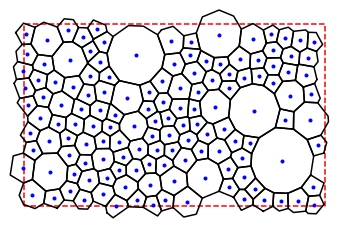

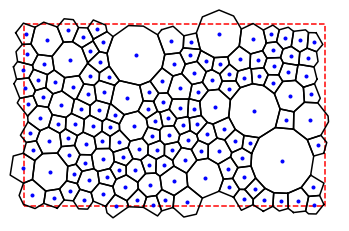

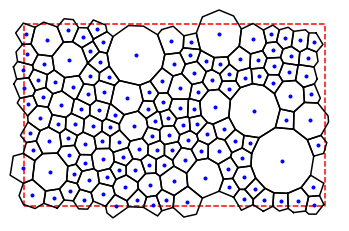

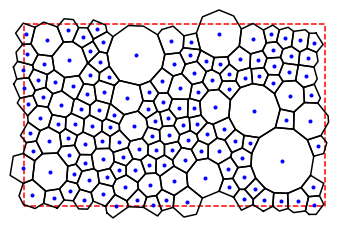

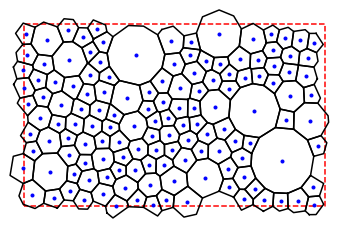

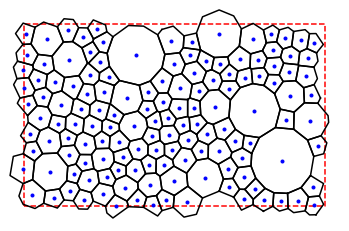

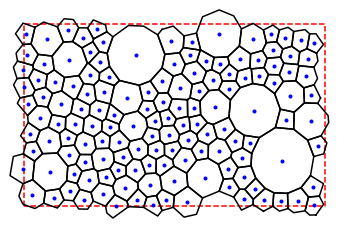

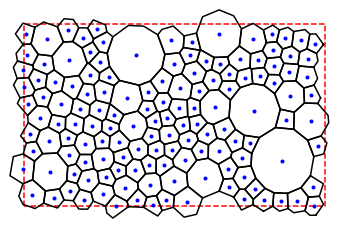

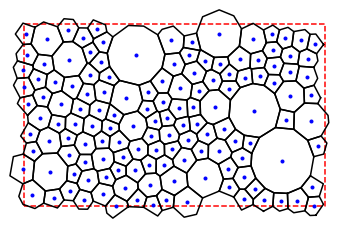

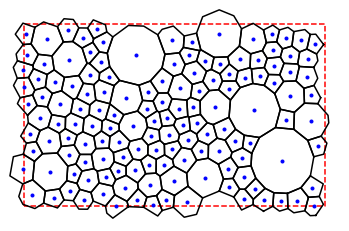

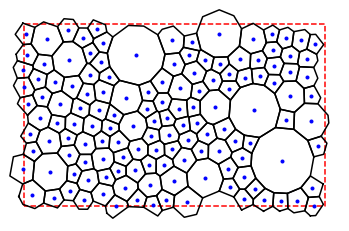

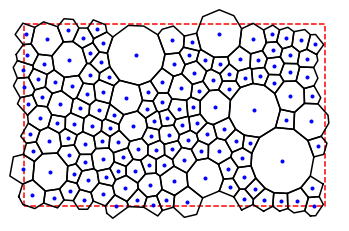

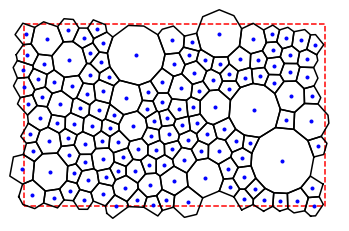

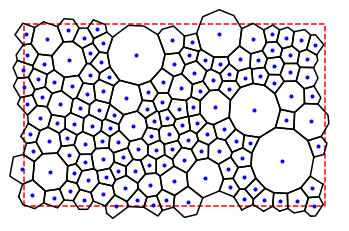

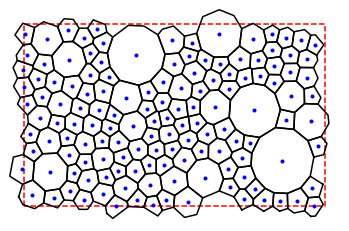

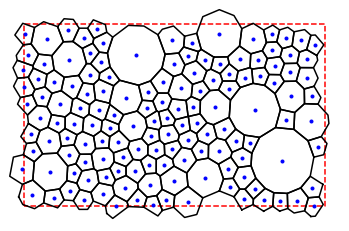

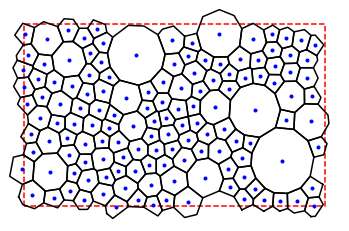

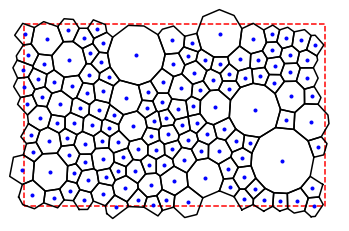

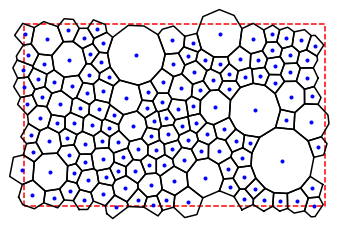

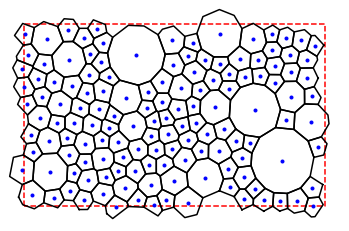

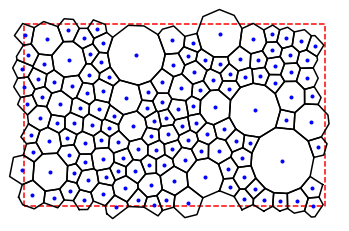

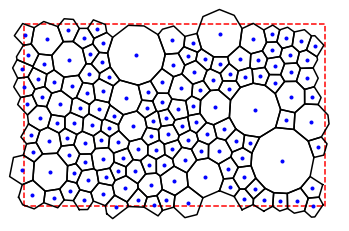

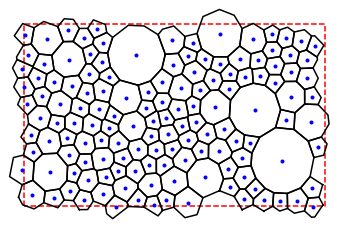

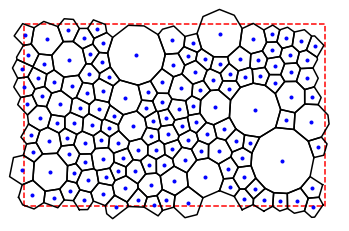

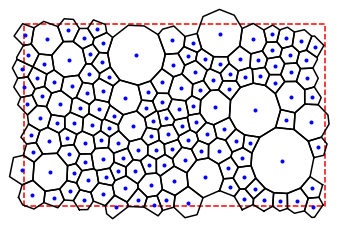

In [40]:
vor,particles_exact = lloyds(points,25)
particles_dense = []

for i in vor:
    verts = i['vertices']
    verts = [j.tolist() for j in verts]
    verts = np.array(verts+[verts[0]])
    
    inscribed_circle = circ_inscribe(verts)
    particles_dense.append(inscribed_circle)


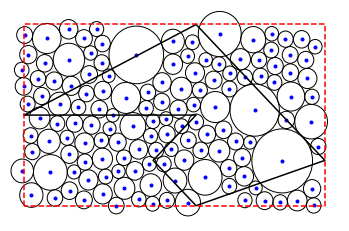

In [49]:
fig, ax = plt.subplots()
for particle in particles_dense:
    plt.plot(particle[0],particle[1],'b.')
    ax.add_patch(plt.Circle((particle[0],particle[1]),particle[2], fill=False, color = 'black'))

# for j in vor:
#     poly = Polygon(j['vertices'])
#     x,y = poly.exterior.xy
#     plt.plot(x,y,'black')

plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')

plt.xlim([xmin-0.4,xmax+0.4])
plt.ylim([ymin-0.4,ymax+0.4])
plt.axis('off')
# plt.savefig('./figs/particles_poly', dpi=300)
plt.show()

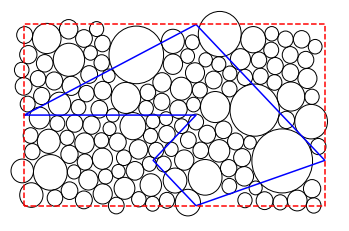

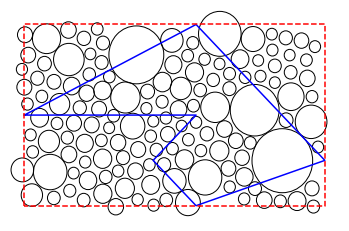

In [50]:
show_particles(particles_dense)
show_particles(particles_exact)

In [ ]:
for i in range(10):
    print(particles_exact[i],' ',points[i])

Packing density of clump = 0.6907885756804024


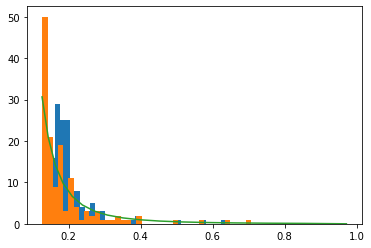

In [53]:
plt.hist(np.array(particles_dense)[:,2],bins=40)
plt.hist(np.array(points)[:,2],bins=40)
plt.plot(size_dist['rad'],size_dist['freq']*n_part*pack_den(particles_exact))
# plt.yscale('log')

In [54]:
def trim(particles):
    shell = Polygon(polygon)
    particles_trimed = np.array([i for i in particles if shell.contains(Point(i[:2]))])
    return particles_trimed

In [95]:
def pack_den(particles):
    poly_area = width*height
    part_area = 0
    for i in particles: part_area += np.pi*i[2]**2
    print(f'Packing density of clump = {part_area/poly_area}')
    return part_area/poly_area

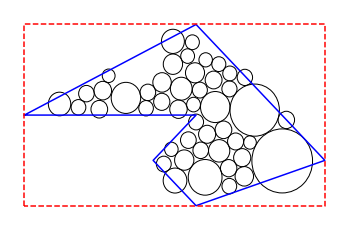

Packing density of clump = 0.8290353068571431


<Figure size 432x288 with 0 Axes>

In [55]:
particles_trimed = trim(particles_dense)
show_particles(particles_trimed)
pack_den(particles_dense)
plt.savefig('particles_dense_trimed')
# particles_trimed = trim(particles_exact)
# show_particles(particles_trimed)
# pack_den(particles_exact)

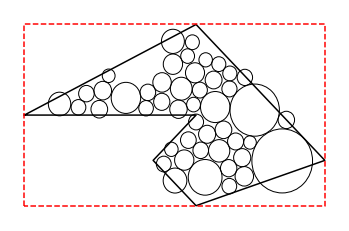

In [57]:
fig, ax = plt.subplots()
for particle in particles_trimed:
    # plt.plot(particle[0],particle[1],'b.')
    ax.add_patch(plt.Circle((particle[0],particle[1]),particle[2], fill=False, color = 'black'))

# for j in vor:
#     poly = Polygon(j['vertices'])
#     x,y = poly.exterior.xy
#     plt.plot(x,y,'black')

plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')

plt.xlim([xmin-0.4,xmax+0.4])
plt.ylim([ymin-0.4,ymax+0.4])
plt.axis('off')
# plt.savefig('./figs/particles_trimmed', dpi=300)
plt.show()

Text(0.5, 0, 'D')

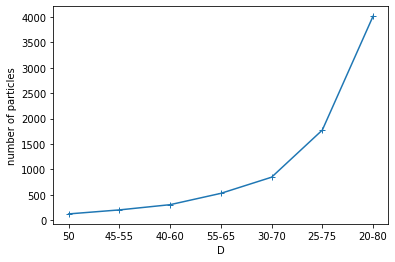

In [3]:
from matplotlib import pyplot as plt
x = ['50','45-55','40-60','55-65','30-70','25-75','20-80']
y = [266,200,303,526,844,1772,4014]

plt.plot(x,y,marker= '+')
plt.ylabel('number of particles')
plt.xlabel('D')
# plt.yscale('log')